In [ ]:
!pip install ase
!git clone https://github.com/Arshnoor7/Machine_Learning_Project
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 6.3 MB/s eta 0:00:00
Cloning into 'Machine_Learning_Project'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (390/390), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 390 (delta 189), reused 380 (delta 183), pack-reused 0 (from 0)
Receiving objects: 100% (390/390), 25.83 MiB | 5.99 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Updating files: 100% (326/326), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 13.6 MB/s eta 0:00:00


In [ ]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi-headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name=f"encoder_{i}_multiheadattention",  # Replaced '/' with '_'
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name=f"encoder_{i}_att_dropout")(attention_output)
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}_att_layernormalization"
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name=f"encoder_{i}_ffn",  # Replaced '/' with '_'
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}_ffn_dropout")(ffn_output)
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}_ffn_layernormalization"
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    position_embeddings = layers.Embedding(input_dim=config.MAX_LEN,output_dim=config.EMBED_DIM,
                                           weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
                                           name="position_embedding",)(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model


In [ ]:
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembertR_'
    MVER = 'V0'
    DSPATH="/content/tox21.csv/"
    PREPATH="/content/Machine_Learning_Project/models/pretrained/"
    PATH="/content/Machine_Learning_Project/models/"
config = Config()
seed=2344567
tf.random.set_seed(seed)
np.random.seed(seed)


In [ ]:
! wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz

--2024-11-20 18:21:54--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.121.98, 52.219.116.161, 52.219.220.130, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.121.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122925 (120K) [application/x-gzip]
Saving to: ‘tox21.csv.gz’

tox21.csv.gz        100%[===================>] 120.04K  --.-KB/s    in 0.05s   

2024-11-20 18:21:54 (2.41 MB/s) - ‘tox21.csv.gz’ saved [122925/122925]



In [ ]:
dsN=10 # set Tox21 column: from 1 to 12 # 10 is sr-mmp
ds = 'tox21_%s' %  dsN
mname=config.PATH+config.MNAME+ds+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)

In [ ]:
from rdkit import Chem
import gzip
with gzip.open('tox21.csv.gz', 'rb') as file:
    df = pd.read_csv(file)
df_filtered = df.dropna(subset=['SR-MMP'])
print(df.head())
types,labels=[],[]
for i,j in zip(df_filtered['smiles'],df_filtered.iloc[:,dsN].to_numpy()):
  try:
    m = Chem.MolFromSmiles(i)
    m = Chem.AddHs(m)
    types.append([atom.GetSymbol() for atom in m.GetAtoms()])
    labels.append(j)
  except:
    pass
uniquelbls=len(np.unique(np.asarray(labels)))
labels  = to_categorical(np.asarray(labels))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


   NR-AR  NR-AR-LBD  NR-AhR  NR-Aromatase  NR-ER  NR-ER-LBD  NR-PPAR-gamma  \
0    0.0        0.0     1.0           NaN    NaN        0.0            0.0   
1    0.0        0.0     0.0           0.0    0.0        0.0            0.0   
2    NaN        NaN     NaN           NaN    NaN        NaN            NaN   
3    0.0        0.0     0.0           0.0    0.0        0.0            0.0   
4    0.0        0.0     0.0           0.0    0.0        0.0            0.0   

   SR-ARE  SR-ATAD5  SR-HSE  SR-MMP  SR-p53    mol_id  \
0     1.0       0.0     0.0     0.0     0.0   TOX3021   
1     NaN       0.0     NaN     0.0     0.0   TOX3020   
2     0.0       NaN     0.0     NaN     NaN   TOX3024   
3     NaN       0.0     NaN     0.0     0.0   TOX3027   
4     0.0       0.0     0.0     0.0     0.0  TOX20800   

                                              smiles  
0                       CCOc1ccc2nc(S(N)(=O)=O)sc2c1  
1                          CCN1C(=O)NC(c2ccccc2)C1=O  
2  CC[C@]1(O)CC[C@H]2[C

[18:21:54] WARNING: not removing hydrogen atom without neighbors


vocabSize:  101


In [ ]:
np.unique(np.asarray(labels))

array([0., 1.])

In [ ]:
print('dataLen: ', len(types), '   OriginalDataLen: ', len(df['smiles']))

dataLen:  5810    OriginalDataLen:  7831


In [ ]:
from collections import defaultdict
element2id = defaultdict(lambda: 1, element2id)
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)


In [ ]:
inputC = Input(shape=(config.MAX_LEN,), dtype=tf.int32, name='types')
z = create_elembert_model(inputC, config)

e = Lambda(lambda x: x[:, 0], name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax", name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

# plot_model(model, show_shapes=True, show_layer_names=True, to_file=mname+".png")

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

model.summary()

csv_logger = tf.keras.callbacks.CSVLogger(mname + "_log.csv", append=True)

mname = config.PATH + config.MNAME + ds + '_%s_E_%s_H_%s_L_%s_bert.keras' % (
    config.MVER, config.EMBED_DIM, config.NUM_HEAD, config.NUM_LAYERS
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    mname,
    verbose=2,
    mode='min',
    save_freq=20000,
)

callbacks_list = [checkpoint, csv_logger]

print('dataLen: ', x3.shape, labels.shape)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ types (InputLayer)        │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ element_embdgs            │ (None, 256, 32)        │          3,232 │ types[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 32)        │              0 │ element_embdgs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_multiheadatten… │ (None, 256, 32)        │          4,224 │ add[0][0], add[0][0],  │
│ (MultiHeadAttention)      │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_att_dropout     │ (None, 256, 32)        │              0 │ encoder_0_multiheadat… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 32)        │              0 │ add[0][0],             │
│                           │                        │                │ encoder_0_att_dropout… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_att_layernorma… │ (None, 256, 32)        │             64 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn             │ (None, 256, 32)        │          2,112 │ encoder_0_att_layerno… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn_dropout     │ (None, 256, 32)        │              0 │ encoder_0_ffn[0][0]    │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 32)        │              0 │ encoder_0_att_layerno… │
│                           │                        │                │ encoder_0_ffn_dropout… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn_layernorma… │ (None, 256, 32)        │             64 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_1_multiheadatten… │ (None, 256, 32)        │          4,224 │ encoder_0_ffn_layerno… │
│ (MultiHeadAttention)      │                        │                │ encoder_0_ffn_layerno… │
│                           │                        │                │ encoder_0_ffn_layerno… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_1_att_dropout     │ (None, 256, 32)        │              0 │ encoder_1_multiheadat… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)          

 Total params: 16,226 (63.38 KB)

 Trainable params: 16,226 (63.38 KB)

 Non-trainable params: 0 (0.00 B)

dataLen:  (5810, 256) (5810, 2)


In [ ]:
epochs=config.BATCH_SIZE*2

p = np.random.RandomState(seed=seed).permutation(len(labels))
n = len(p)

trainidx=p[:int(len(p)*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

trainlog = model.fit(x=x3[trainidx], y=labels[trainidx],
                     validation_data = (x3[validx],labels[validx]),
                     verbose = 1,epochs = epochs, batch_size = config.BATCH_SIZE,callbacks = callbacks_list)

model.save(mname+".h5")

Epoch 1/64
146/146 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - auc: 0.8055 - loss: 0.5583 - val_auc: 0.8568 - val_loss: 0.4381
Epoch 2/64
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8447 - loss: 0.4464 - val_auc: 0.8722 - val_loss: 0.4363
Epoch 3/64
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.8569 - loss: 0.4328 - val_auc: 0.8922 - val_loss: 0.4061
Epoch 4/64
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8891 - loss: 0.4085 - val_auc: 0.9012 - val_loss: 0.4036
Epoch 5/64
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.8922 - loss: 0.4060 - val_auc: 0.9054 - val_loss: 0.3940
Epoch 6/64
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8989 - loss: 0.3959 - val_auc: 0.9079 - val_loss: 0.3880
Epoch 7/64
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9040 - loss: 0.3885 - val_auc: 0.9114 - val_loss: 0.3822
Epoch 8/64
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9087 - loss: 0.3793 - val_auc: 0.9131 - val_loss: 0.3829
Epoch 9/64
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - 

In [ ]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['smiles']
dbresults['ids'] = df.iloc[:,0]
dbresults['types'] = types
dbresults['trainidx'] = trainidx
dbresults['testidx'] = testidx
dbresults['validx'] = validx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [ ]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [ ]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1))
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1))
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]

binary tf-acc: [1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1.

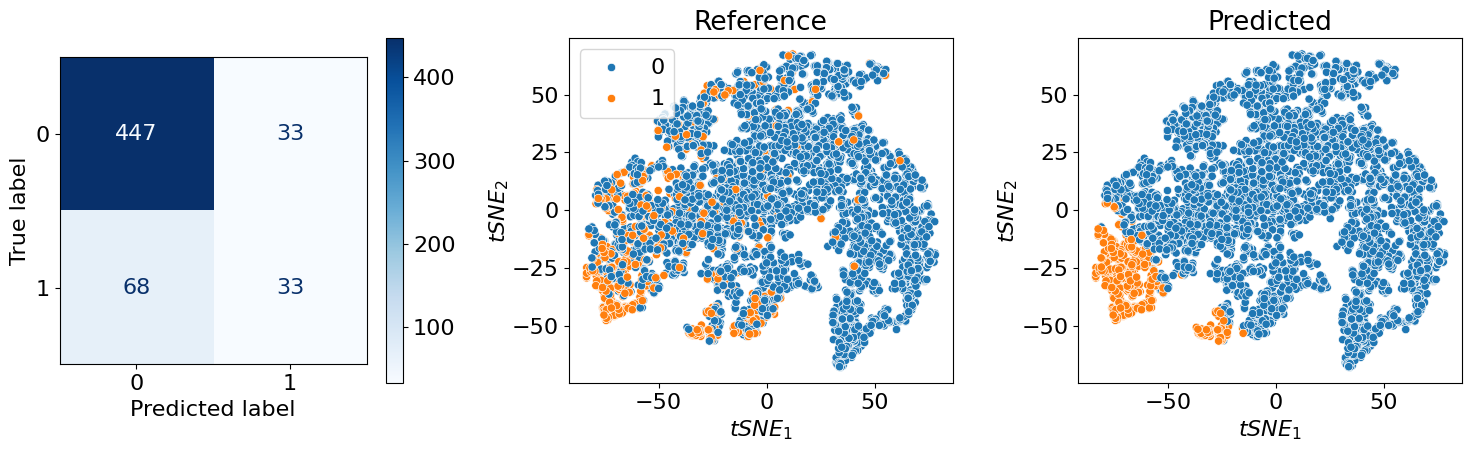

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'][dbresults['testidx']].argmax(axis=-1)
y_classes = dbresults['y_cls'][dbresults['testidx']].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'][dbresults['testidx']], dbresults['pred_cls'][dbresults['testidx']])
print(mname, ' AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")